In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, time, shutil
from PIL import Image
from time import gmtime, strftime
import csv
import cv2
import glob
import serial,sys
import signal


path="C:\\Users\\ЛФКИТ-3\\Documents\\Interferom\\img\\seq24_09\\"
from IPython.display import clear_output
from IPython import display

%matplotlib inline



In [2]:
#shutil.rmtree(path)
#os.makedirs(path)
cam_idx = 0
caps = [cv2.VideoCapture(i) for i in [cam_idx] ]
# Set exposition time-------
for cap in caps:
    cap.set(15, 0.1)
# 
retry_sec = 0.5
retry_cnt = 5

def gen_int_handler(caps):
    def int_handler(signum, frame):
        print("Got sigterm, releasing cameras")
        for cap in caps:
            cap.release()
        raise  Exception('Interrupt') 
        #cv2.destroyAllWindows()
    return int_handler


def upd_plot(new_seq=[]):
    display.clear_output(wait=True)
    plt.plot(new_seq)
    display.display(plt.show())
    
def counter(dt):
    was = False
    count = time.time()//dt+1
    while True:
        t = time.time()
        if t//dt==count:
            was = True
            count+=1
            yield t
        time.sleep(0.001)
        import sys


%matplotlib inline



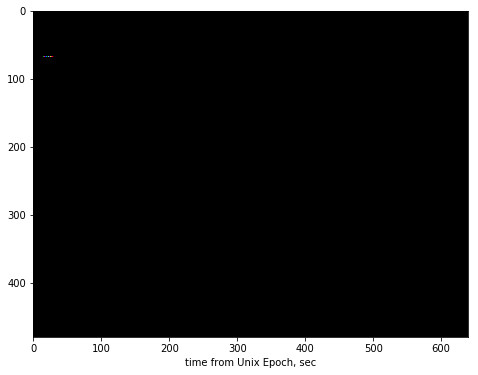

got 1 new shots. Intensity: 0.005756, stddev 0.000000
 iter tme: 1.8880980014801025
Got sigterm, releasing cameras


Exception: Interrupt

In [3]:
files = []
intens = []
stddevs=[]
times=[]
#start =time.time()
cam_shot_interval = 0.5
#mean_over_shots = 50
mean_over_time = 2    # seconds
display_time = 20
time_ = 0.0
signal.signal(signal.SIGINT, gen_int_handler(caps))

count = time.time()//mean_over_time+1
iter_start = time.time()
ins = []
img = []
while True:
    num = 0
    iter_start = time.time()
    ins = []
    while True:
        t = time.time()
        if t//mean_over_time<count:
            for cap in caps:
                tries=0
                img, ret = None, False
                while True:
                    ret, img = cap.read()
                    if not ret:
                        tries+=1
                        print("Camera %i returned None %i times. retry in %f seconds"%(cam_idx,tries,retry_sec))
                        if (tries==retry_cnt):
                            print("Camera %i is not working. Giving up."%num)
                            print()
                            break
                        time.sleep(retry_sec)
                    else:
                        cv2.imshow("camera%i"%num, img)
                        mean = np.mean(img)
                        print("read from %i cam value %f"%(num,mean))
                        # Sucessfully read, go for next cam
                        ins.append(mean)
                        break
            time.sleep(cam_shot_interval)
        else:
            count+=1
            print("ending measurm")
            break
    ints = np.mean(ins)
    sdev = np.std(ins)
    if not np.isnan(ints):
        intens.append(ints)
        stddevs.append(sdev)
        times.append(t)

    points_num = int(display_time//mean_over_time+1)
    display_obj = (np.array(intens[-points_num:]),
                   np.array(stddevs[-points_num:]))

    display.clear_output(wait=True)
    f,ax = plt.subplots(figsize=(12,6))
    # plot intensities
    ax.plot(times[-points_num:],display_obj[0])
    # plot standart deviation
    ax.fill_between(times[-points_num:], display_obj[0]+display_obj[1],
                     display_obj[0]-display_obj[1], facecolor='blue', alpha=0.1)
    plt.xlabel('time from Unix Epoch, sec')
    plt.imshow( np.array(img))
    plt.show()

    #display.display(plt.show())

    print('got %i new shots. Intensity: %f, stddev %f'%
          (len(ins), ints, sdev )) 
    print(' iter tme:',time.time() - iter_start)


In [ ]:
# SAVING TO FILE
save_to="C:\\Users\\ЛФКИТ-3\\Documents\\Interferom\\data\\"+\
        "data_%s_port2.csv"%time.strftime('%d-%m-%Y_%H-%M')

print('total number of points: %i'%len(intens))
result = np.array(intens)
## times = np.arange(0,len(intens),file_check_interval)
data = np.stack((result,times)).T
print(data.shape)
np.savetxt(save_to,data,delimiter=',',fmt='%10.5f')
print ("saved to %s"%save_to)

In [ ]:
time.strftime('-%x-%H:%M')


In [ ]:
for i in counter(0.2):
    print(i)

In [ ]:
today = time.asctime()
#today
087.5959406%1.5
rem = 087.5959406%1.5



In [ ]:
87.5959406//1.5


In [ ]:
1.5*58 + rem
rem
